# Long Short-Term Memory (LSTM) for Fertility Rate Prediction

This notebook implements an LSTM network to predict fertility rates using sequential time-series data.

## Why LSTM?
LSTMs are an advanced type of RNN that solve the "vanishing gradient" problem. They have special gates that allow them to:
- Remember important information from long ago
- Forget irrelevant information
- Learn long-term dependencies better than simple RNNs

## Architecture:
- Input: Sequences of 5 years × 29 features
- LSTM layers: LSTM cells with dropout
- Output layer: Single neuron (regression)
- LSTMs typically outperform simple RNNs on time-series tasks

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn for metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("Libraries imported successfully!")

TensorFlow version: 2.20.0
GPU available: []
Libraries imported successfully!


## 1. Load Preprocessed Sequence Data

In [2]:
# Load preprocessed sequence data
data_dir = '../data/processed'

X_train_seq = np.load(f'{data_dir}/X_train_seq.npy')
y_train_seq = np.load(f'{data_dir}/y_train_seq.npy')
X_val_seq = np.load(f'{data_dir}/X_val_seq.npy')
y_val_seq = np.load(f'{data_dir}/y_val_seq.npy')
X_test_seq = np.load(f'{data_dir}/X_test_seq.npy')
y_test_seq = np.load(f'{data_dir}/y_test_seq.npy')

# Load configuration
with open(f'{data_dir}/config.json', 'r') as f:
    config = json.load(f)

print("Sequence data loaded successfully!")
print("="*80)
print(f"Training set:   X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"Validation set: X={X_val_seq.shape}, y={y_val_seq.shape}")
print(f"Test set:       X={X_test_seq.shape}, y={y_test_seq.shape}")
print(f"\nSequence structure:")
print(f"  - Sequence length: {X_train_seq.shape[1]} time steps")
print(f"  - Features per time step: {X_train_seq.shape[2]}")
print(f"\nData split years:")
print(f"  Train: {config['train_years']}")
print(f"  Val:   {config['val_years']}")
print(f"  Test:  {config['test_years']}")

Sequence data loaded successfully!
Training set:   X=(9299, 5, 29), y=(9299,)
Validation set: X=(434, 5, 29), y=(434,)
Test set:       X=(217, 5, 29), y=(217,)

Sequence structure:
  - Sequence length: 5 time steps
  - Features per time step: 29

Data split years:
  Train: 1963-2010
  Val:   2011-2017
  Test:  2018-2023


In [3]:
# Load sequence metadata to understand the data better
train_meta = pd.read_csv(f'{data_dir}/train_seq_metadata.csv')
val_meta = pd.read_csv(f'{data_dir}/val_seq_metadata.csv')
test_meta = pd.read_csv(f'{data_dir}/test_seq_metadata.csv')

print("Example sequences from training data:")
print("="*80)
print(train_meta.head(10))
print(f"\nEach sequence uses {config['sequence_length']} years of history to predict the next year's fertility rate.")

Example sequences from training data:
       Country  Last_Year_in_Sequence  Target_Year
0  Afghanistan                 1967.0       1968.0
1  Afghanistan                 1968.0       1969.0
2  Afghanistan                 1969.0       1970.0
3  Afghanistan                 1970.0       1971.0
4  Afghanistan                 1971.0       1972.0
5  Afghanistan                 1972.0       1973.0
6  Afghanistan                 1973.0       1974.0
7  Afghanistan                 1974.0       1975.0
8  Afghanistan                 1975.0       1976.0
9  Afghanistan                 1976.0       1977.0

Each sequence uses 5 years of history to predict the next year's fertility rate.


## 2. Build the LSTM Model

We'll create an LSTM with:
- LSTM layers (more sophisticated than SimpleRNN)
- Dropout and recurrent dropout for regularization
- Dense layers for final prediction

In [4]:
def build_lstm_model(sequence_length, n_features, lstm_units=[64, 32], dropout_rate=0.3):
    """
    Build an LSTM network for time-series regression.
    
    Parameters:
    - sequence_length: Number of time steps in each sequence
    - n_features: Number of features per time step
    - lstm_units: List of units in each LSTM layer
    - dropout_rate: Dropout rate for regularization
    
    Returns:
    - Compiled Keras model
    """
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(sequence_length, n_features)))
    
    # LSTM layers
    for i, units in enumerate(lstm_units[:-1]):
        # return_sequences=True means output sequence for next LSTM layer
        # recurrent_dropout helps prevent overfitting in recurrent connections
        model.add(layers.LSTM(
            units,
            return_sequences=True,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate * 0.5,  # Typically lower than regular dropout
            name=f'lstm_{i+1}'
        ))
    
    # Last LSTM layer (return_sequences=False to output single vector)
    model.add(layers.LSTM(
        lstm_units[-1],
        return_sequences=False,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate * 0.5,
        name=f'lstm_{len(lstm_units)}'
    ))
    
    # Dense layers for final prediction
    model.add(layers.Dense(16, activation='relu', name='dense_1'))
    model.add(layers.Dropout(dropout_rate, name='dropout_final'))
    
    # Output layer (single neuron for regression)
    model.add(layers.Dense(1, name='output'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

print("LSTM model builder function defined!")

LSTM model builder function defined!


In [5]:
# Build the LSTM model
lstm_model = build_lstm_model(
    sequence_length=X_train_seq.shape[1],
    n_features=X_train_seq.shape[2],
    lstm_units=[64, 32],
    dropout_rate=0.3
)

# Display model architecture
print("LSTM Model Architecture:")
print("="*80)
lstm_model.summary()

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,025 (144.63 KB)

 Trainable params: 37,025 (144.63 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Set Up Training Callbacks

In [7]:
# Create directory for saving models
import os
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=f'{model_dir}/lstm_best.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

callback_list = [early_stopping, model_checkpoint, reduce_lr]

print("Callbacks configured:")
print("  - EarlyStopping (patience=25)")
print("  - ModelCheckpoint (save best model)")
print("  - ReduceLROnPlateau (reduce LR on plateau)")

Callbacks configured:
  - EarlyStopping (patience=25)
  - ModelCheckpoint (save best model)
  - ReduceLROnPlateau (reduce LR on plateau)


## 4. Train the LSTM Model

In [8]:
# Train the model
print("Starting LSTM training...")
print("="*80)
print("Note: LSTMs have more parameters than simple RNNs, so training may take longer.\n")

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=32,
    callbacks=callback_list,
    verbose=1
)

print("\n" + "="*80)
print("LSTM training complete!")

Starting LSTM training...
Note: LSTMs have more parameters than simple RNNs, so training may take longer.

Epoch 1/200
286/291 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8069 - mae: 2.0036 - mse: 6.8069
Epoch 1: val_loss improved from None to 0.62542, saving model to ../models/lstm_best.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.7798 - mae: 1.4504 - mse: 3.7798 - val_loss: 0.6254 - val_mae: 0.5625 - val_mse: 0.6254 - learning_rate: 0.0010
Epoch 2/200
287/291 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1487 - mae: 1.1129 - mse: 2.1487
Epoch 2: val_loss improved from 0.62542 to 0.62069, saving model to ../models/lstm_best.keras
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0485 - mae: 1.0862 - mse: 2.0485 - val_loss: 0.6207 - val_mae: 0.5646 - val_mse: 0.6207 - learning_rate: 0.0010
Epoch 3/200
285/291 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9198 - mae: 1.0544 - mse: 1.9198
Epoch 3: val_loss did not improve from 0.62069
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss

## 5. Visualize Training History

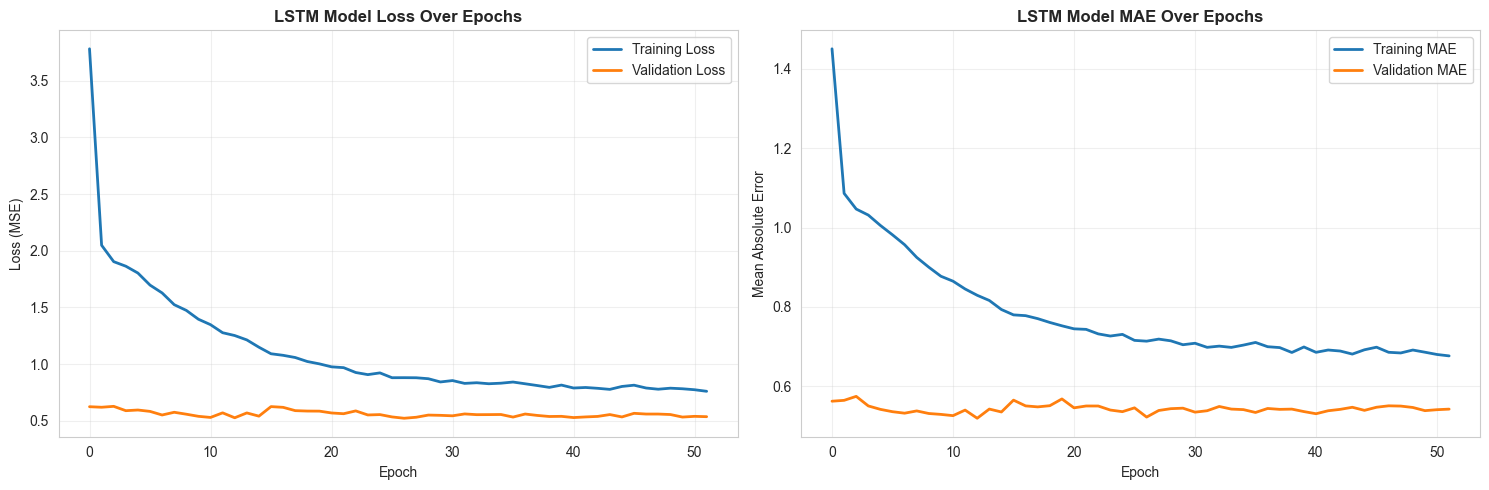


Best model at epoch 27 with validation loss: 0.5237


In [9]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('LSTM Model Loss Over Epochs', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_title('LSTM Model MAE Over Epochs', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
print(f"\nBest model at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")

## 6. Evaluate on Test Set

In [10]:
# Load best model
best_lstm_model = keras.models.load_model(f'{model_dir}/lstm_best.keras')
print("Best LSTM model loaded!")

# Make predictions on all sets
y_train_pred = best_lstm_model.predict(X_train_seq, verbose=0).flatten()
y_val_pred = best_lstm_model.predict(X_val_seq, verbose=0).flatten()
y_test_pred = best_lstm_model.predict(X_test_seq, verbose=0).flatten()

# Calculate metrics
def calculate_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Set Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

print("="*80)
print("LSTM MODEL EVALUATION")
print("="*80)

train_metrics = calculate_metrics(y_train_seq, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val_seq, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test_seq, y_test_pred, "Test")

print("\n" + "="*80)

Best LSTM model loaded!
LSTM MODEL EVALUATION

Training Set Metrics:
  RMSE: 0.6990
  MAE:  0.5398
  R²:   0.8748

Validation Set Metrics:
  RMSE: 0.7237
  MAE:  0.5225
  R²:   0.7017

Test Set Metrics:
  RMSE: 0.7485
  MAE:  0.5713
  R²:   0.6125



## 7. Visualize Predictions

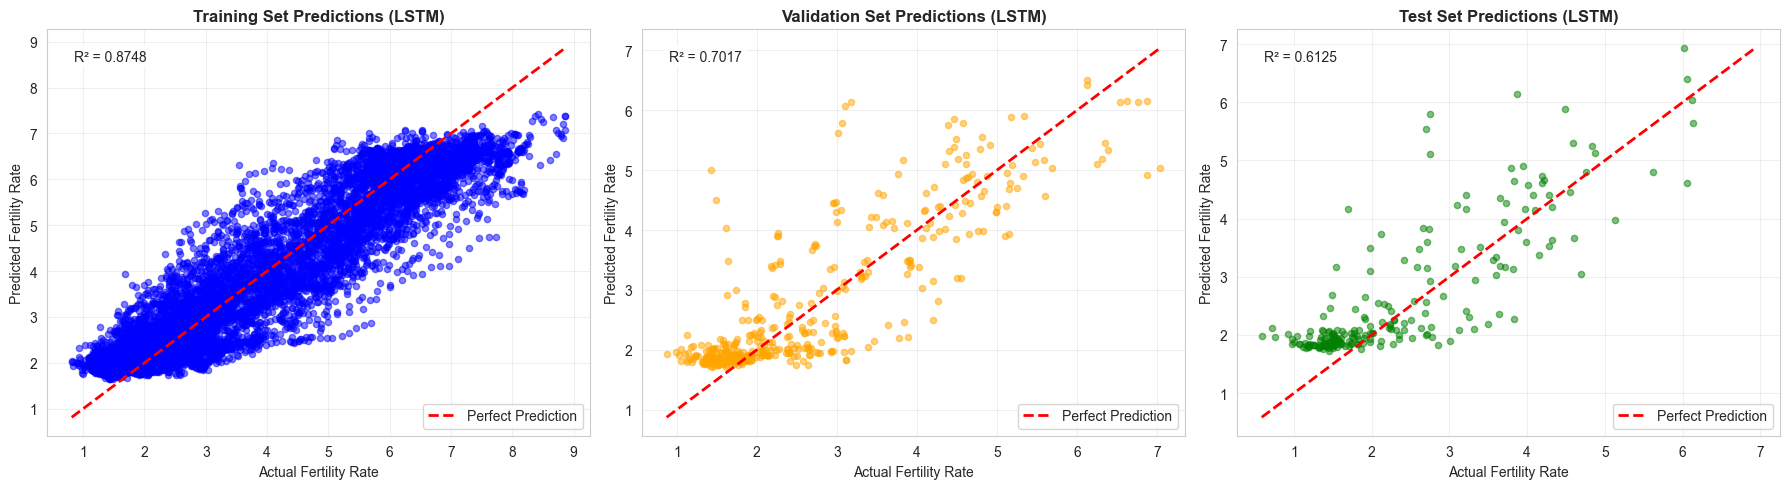

In [11]:
# Create prediction plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (y_train_seq, y_train_pred, 'Training', 'blue'),
    (y_val_seq, y_val_pred, 'Validation', 'orange'),
    (y_test_seq, y_test_pred, 'Test', 'green')
]

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    # Scatter plot
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=20, color=color)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Labels and title
    axes[idx].set_xlabel('Actual Fertility Rate')
    axes[idx].set_ylabel('Predicted Fertility Rate')
    axes[idx].set_title(f'{name} Set Predictions (LSTM)', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Add R² to plot
    r2 = r2_score(y_true, y_pred)
    axes[idx].text(0.05, 0.95, f'R² = {r2:.4f}', 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

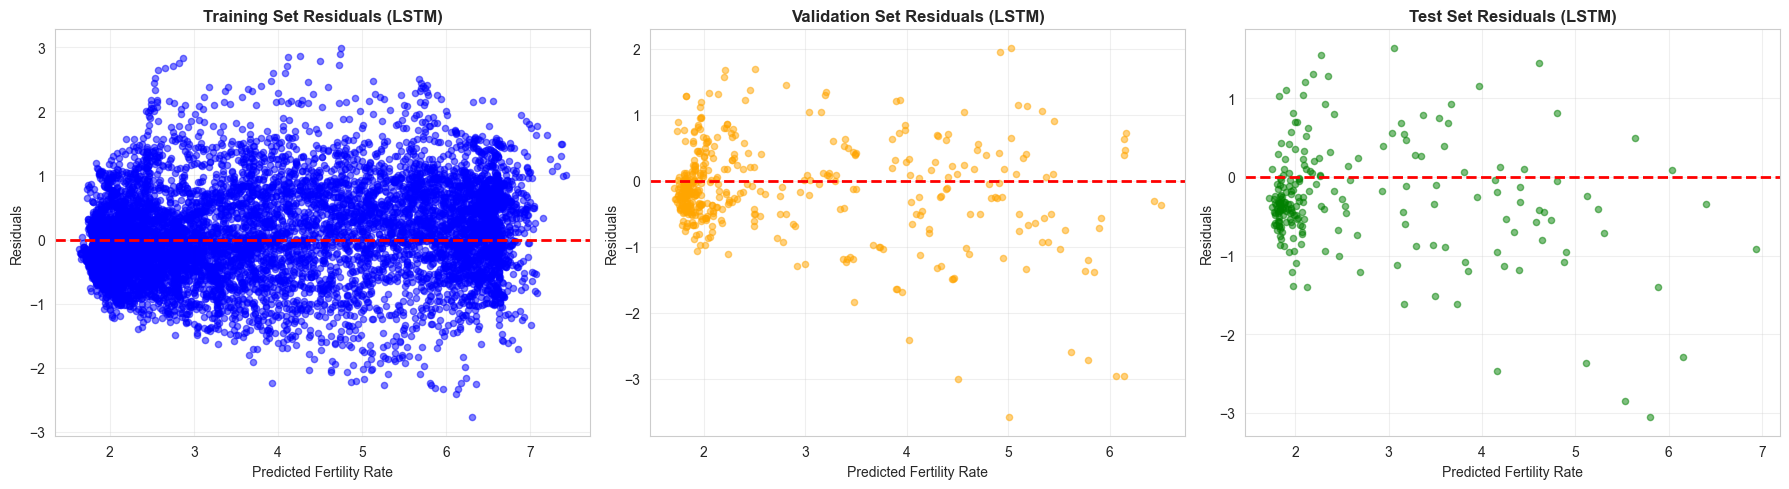

In [12]:
# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    residuals = y_true - y_pred
    
    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20, color=color)
    axes[idx].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Predicted Fertility Rate')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name} Set Residuals (LSTM)', fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

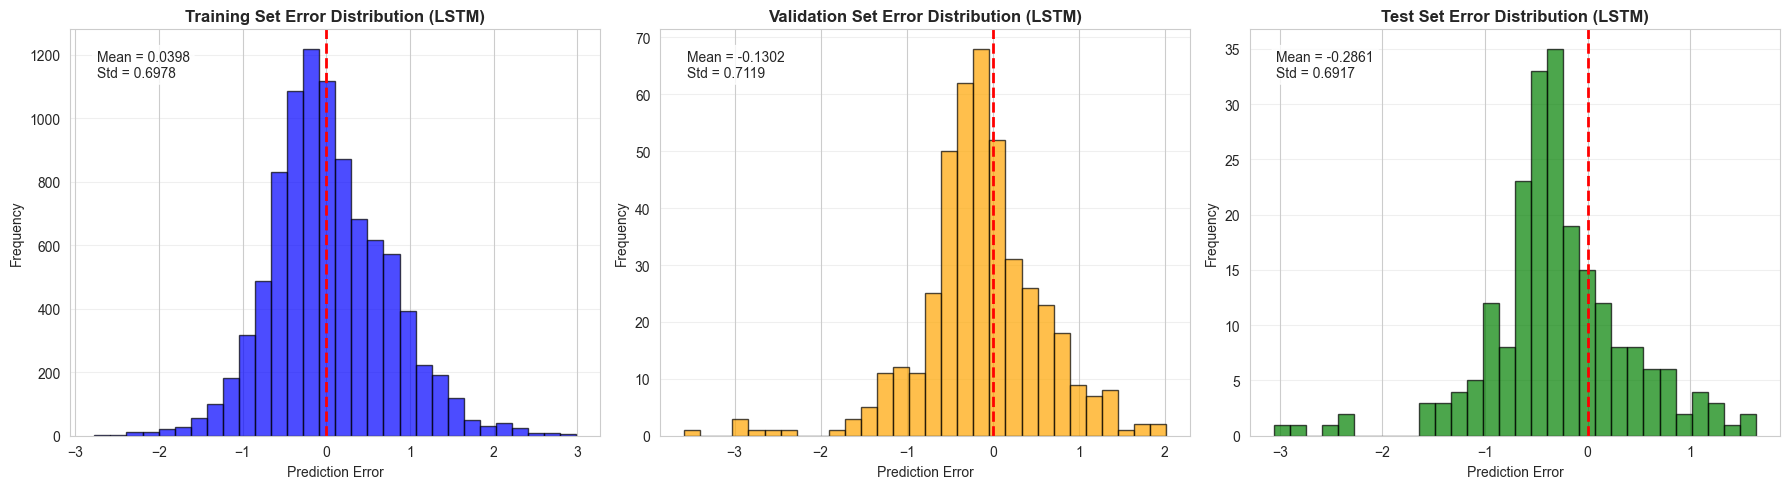

In [13]:
# Distribution of errors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (y_true, y_pred, name, color) in enumerate(datasets):
    errors = y_true - y_pred
    
    axes[idx].hist(errors, bins=30, color=color, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Prediction Error')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{name} Set Error Distribution (LSTM)', fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add mean and std to plot
    axes[idx].text(0.05, 0.95, f'Mean = {errors.mean():.4f}\nStd = {errors.std():.4f}', 
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Analyze Temporal Predictions

Visualize how well the LSTM predicts over time for sample countries.

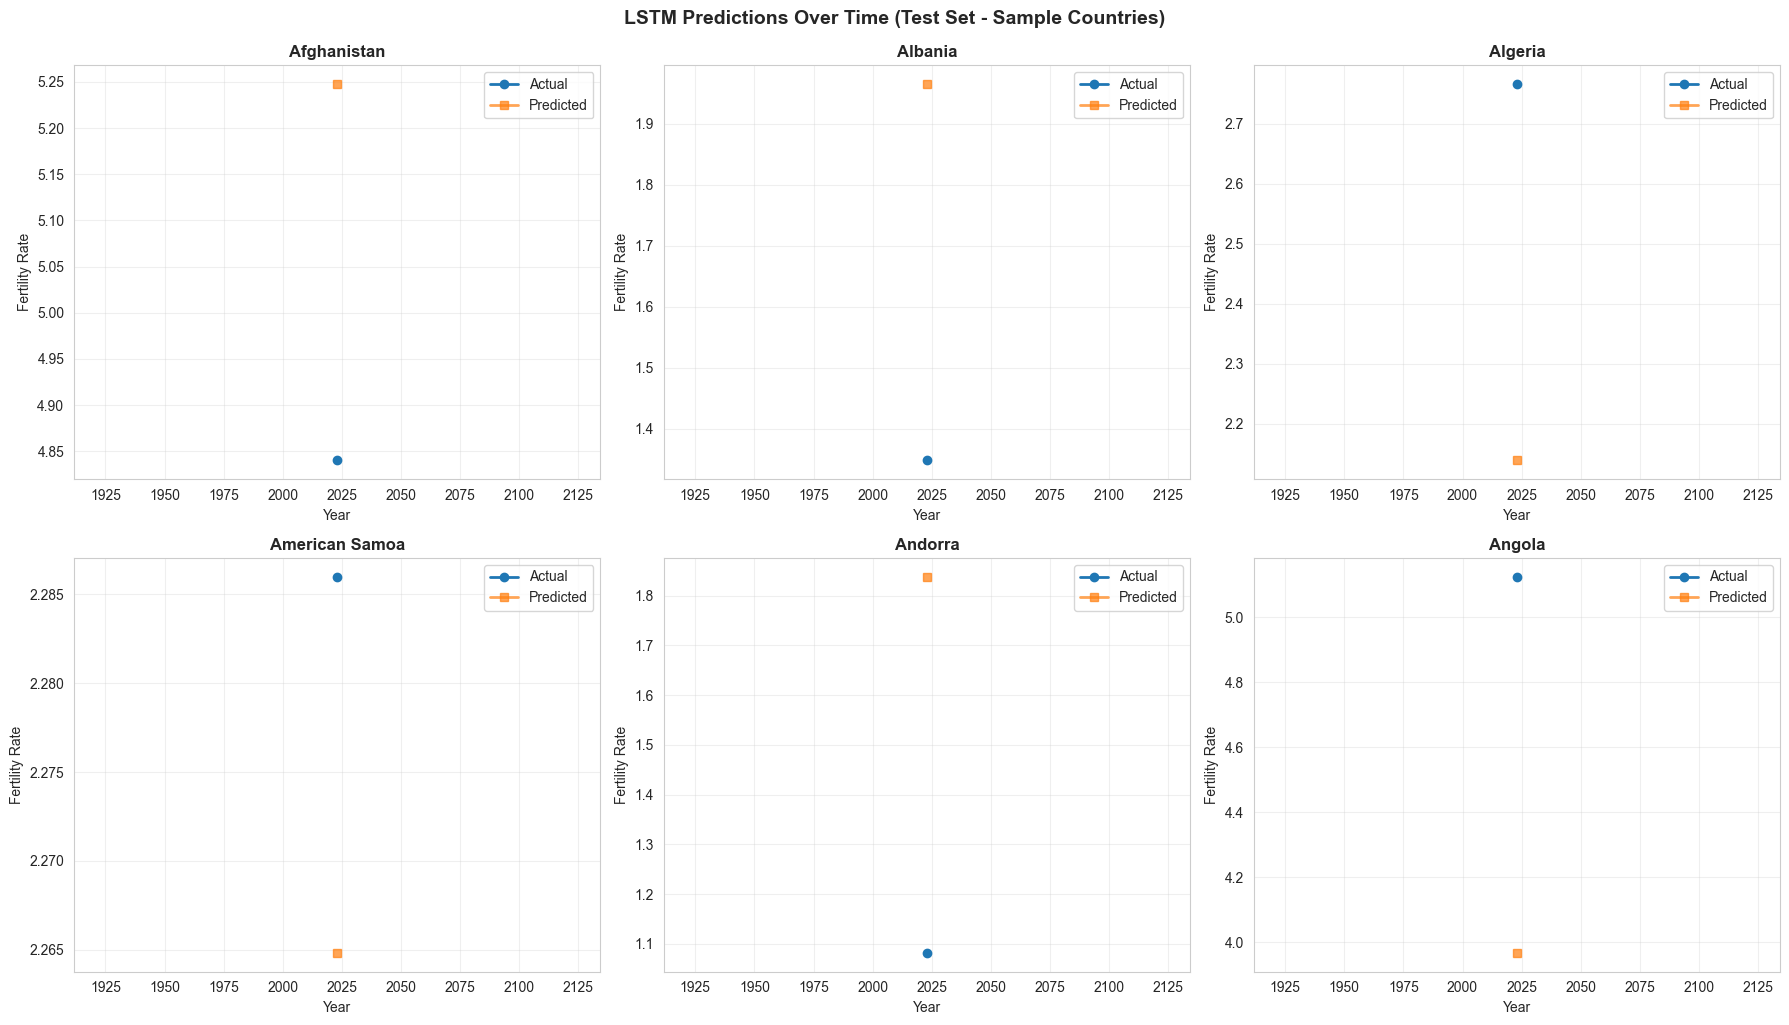

In [14]:
# Analyze predictions for sample countries
sample_countries = test_meta['Country'].unique()[:6]  # First 6 countries in test set

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, country in enumerate(sample_countries):
    # Get data for this country
    country_mask = test_meta['Country'] == country
    country_years = test_meta[country_mask]['Target_Year'].values
    country_true = y_test_seq[country_mask]
    country_pred = y_test_pred[country_mask]
    
    # Plot
    axes[idx].plot(country_years, country_true, marker='o', label='Actual', linewidth=2)
    axes[idx].plot(country_years, country_pred, marker='s', label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Fertility Rate')
    axes[idx].set_title(f'{country}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('LSTM Predictions Over Time (Test Set - Sample Countries)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 9. Save Results

In [15]:
# Save predictions
results = {
    'train': {'y_true': y_train_seq, 'y_pred': y_train_pred, 'metrics': train_metrics},
    'val': {'y_true': y_val_seq, 'y_pred': y_val_pred, 'metrics': val_metrics},
    'test': {'y_true': y_test_seq, 'y_pred': y_test_pred, 'metrics': test_metrics}
}

# Save as pickle
with open(f'{model_dir}/lstm_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save metrics as JSON
metrics_summary = {
    'train': train_metrics,
    'val': val_metrics,
    'test': test_metrics,
    'model_config': {
        'lstm_units': [64, 32],
        'dropout_rate': 0.3,
        'recurrent_dropout_rate': 0.15,
        'sequence_length': config['sequence_length'],
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'batch_size': 32,
        'total_epochs': len(history.history['loss']),
        'best_epoch': int(best_epoch)
    }
}

with open(f'{model_dir}/lstm_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

print("Results saved successfully!")
print(f"  - Model: {model_dir}/lstm_best.keras")
print(f"  - Results: {model_dir}/lstm_results.pkl")
print(f"  - Metrics: {model_dir}/lstm_metrics.json")

Results saved successfully!
  - Model: ../models/lstm_best.keras
  - Results: ../models/lstm_results.pkl
  - Metrics: ../models/lstm_metrics.json


## 10. Summary

In [16]:
print("="*80)
print("LSTM MODEL - FINAL SUMMARY")
print("="*80)
print("\nModel Architecture:")
print(f"  - Input: {X_train_seq.shape[1]} time steps × {X_train_seq.shape[2]} features")
print(f"  - LSTM layers: [64, 32] units")
print(f"  - Total parameters: {lstm_model.count_params():,}")
print(f"  - Regularization: Dropout (0.3) + Recurrent Dropout (0.15)")

print("\nTraining:")
print(f"  - Total epochs: {len(history.history['loss'])}")
print(f"  - Best epoch: {best_epoch}")
print(f"  - Batch size: 32")
print(f"  - Optimizer: Adam (lr=0.001)")

print("\nFinal Performance:")
print("\n  Training Set:")
print(f"    RMSE: {train_metrics['rmse']:.4f}")
print(f"    MAE:  {train_metrics['mae']:.4f}")
print(f"    R²:   {train_metrics['r2']:.4f}")

print("\n  Validation Set:")
print(f"    RMSE: {val_metrics['rmse']:.4f}")
print(f"    MAE:  {val_metrics['mae']:.4f}")
print(f"    R²:   {val_metrics['r2']:.4f}")

print("\n  Test Set:")
print(f"    RMSE: {test_metrics['rmse']:.4f}")
print(f"    MAE:  {test_metrics['mae']:.4f}")
print(f"    R²:   {test_metrics['r2']:.4f}")

print("\n" + "="*80)
print("✓ LSTM training complete!")
print("="*80)

LSTM MODEL - FINAL SUMMARY

Model Architecture:
  - Input: 5 time steps × 29 features
  - LSTM layers: [64, 32] units
  - Total parameters: 37,025
  - Regularization: Dropout (0.3) + Recurrent Dropout (0.15)

Training:
  - Total epochs: 52
  - Best epoch: 27
  - Batch size: 32
  - Optimizer: Adam (lr=0.001)

Final Performance:

  Training Set:
    RMSE: 0.6990
    MAE:  0.5398
    R²:   0.8748

  Validation Set:
    RMSE: 0.7237
    MAE:  0.5225
    R²:   0.7017

  Test Set:
    RMSE: 0.7485
    MAE:  0.5713
    R²:   0.6125

✓ LSTM training complete!
